### <center> **Machine Learning- Insurance Claim Prediction** </center>

---

**<center> Author: Aravindan Natarajan </center>**
**<center>Version: 2.0</center>**

---

### **Data Summary**

An Insurance firm providing tour insurance is facing higher claim frequency. The management decides to collect data from the past few years. You are assigned the task to make a model which predicts the claim status and provide recommendations to management.

**<center> Data Dictionary </center>**

---

| # | Feature | Description | Units/Format |
|---|---|---|---|
| 1 | Target: Claimed | Claim Status | Claimed (Yes/No or 1/0) |
| 2 | Agency_Code | Code of tour firm | Alphanumeric code |
| 3 | Type | Type of tour insurance firms | Categorical |
| 4 | Channel | Distribution channel | Categorical |
| 5 | Product Name | Name of the tour insurance products | Text |
| 6 | Duration | Duration of the tour | Days (Numeric) |
| 7 | Destination | Destination of the tour | Text/Categorical |
| 8 | Sales | Amount worth of sales per customer | Rupees (in 100's, Numeric) |
| 9 | Commission | Commission received for tour insurance firm | Percentage of sales (Numeric) |
| 10 | Age | Age of insured | Years (Numeric) |

### **1. Import the Required Libraries**

In [ ]:
# Import basic packages
import pandas as pd
import numpy as np
import itertools

# Import visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='ticks', color_codes=True)
%matplotlib inline
from IPython.display import Image
import pydotplus

# Set colour palette
palette = itertools.cycle(sns.color_palette())

# Import Statistical Packages
import statsmodels.api as sm
from scipy.stats import shapiro
from sklearn.preprocessing import StandardScaler

# Import Machine Learning Models
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score,accuracy_score,roc_auc_score,roc_curve, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

# Import train-test split
from sklearn.model_selection import train_test_split

# Import cross-validation
from sklearn.model_selection import cross_val_score

# Warning handling
import warnings
warnings.filterwarnings("ignore")

### **2. Some Useful Functions**

In [ ]:
# Annotation function to display the numbers above bar for bargraphs

def annotate_values(ax, orientation='v'):
  # Display counts at the top of the bars
  for p in ax.patches:
        if orientation == 'v':
            ax.annotate(format(p.get_height(), '.0f'),
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center',
                        xytext=(0, 10),
                        textcoords='offset points',
                        fontsize=8)

        elif orientation == 'h':
            ax.annotate(format(p.get_width(), '.0f'),
                        (p.get_width(), p.get_y() + p.get_height() / 2.),
                        ha='left', va='center',
                        xytext=(5, 0),
                        textcoords='offset points',
                        fontsize=8)

In [ ]:
# Function for plotting a countplot

def plot_countplot(df, column, hue=None, hue_order=None):
  plt.figure(figsize=(10, 6))

  # If hue is provided, use it in the countplot
  if hue:
    counts = df.groupby([column, hue]).size().reset_index(name='count')
    order = counts.sort_values('count', ascending=False)[column].unique()
    ax = sns.countplot(x=column, data=df, order=order, hue=hue, hue_order=hue_order)
  else:
    counts = df[column].value_counts().sort_values(ascending=False)
    ax = sns.countplot(x=column, data=df, order=counts.index)

  plt.xticks(rotation=90)
  plt.title(f'Count Plot of {column}')
  plt.xlabel(f'{column}')
  plt.ylabel(f'Count of {column}')
  annotate_values(ax)
  plt.show()

In [ ]:
# Function similar to plot_countplot named as plot_barplot

def plot_barplot(df, x_col, y_col, hue=None, hue_order=None):
    plt.figure(figsize=(10, 6))

    # Sort x_col values in ascending order
    order = df[x_col].sort_values().unique()

    if hue:
        ax = sns.barplot(x=x_col, y=y_col, data=df, hue=hue, hue_order=hue_order, order=order, palette='Set1',ci=None)  # ci=None removes error bars
    else:
        ax = sns.barplot(x=x_col, y=y_col, data=df, order=order, palette='Set1', ci=None)

    plt.xticks(rotation=90)
    plt.title(f'Bar Plot of {y_col} vs {x_col}')
    plt.xlabel(f'{x_col}')
    plt.ylabel(f'{y_col}')
    annotate_values(ax)
    plt.show()

In [ ]:
# Function to annotate a Seaborn box plot with quartiles, IQR, maximum, and minimum values.

def annotate_boxplot(data_series, ax=None):

    # Calculate quartiles and IQR
    q1, q2, q3 = data_series.quantile([0.25, 0.5, 0.75])
    iqr = q3 - q1

    # Get minimum and maximum values
    data_min = data_series.min()
    data_max = data_series.max()

    # Get plot limits
    x_min, x_max = ax.get_xlim()
    x_range = x_max - x_min

    # Adjust figure size based on x-range
    fig = plt.gcf()
    fig.set_size_inches(10 + x_range/20, 15)  # Adjust these values as needed

    # Annotate quartiles and IQR without arrows
    ax.text(q1, -0.3, f"Q1: {q1:.2f}", ha='center')
    ax.text(q2, 0.3, f"Q2 (Median): {q2:.2f}", ha='center')
    ax.text(q3, -0.4, f"Q3: {q3:.2f}", ha='center')
    #ax.text((q1+q3)/2, 0.3, f"IQR: {iqr:.2f}", ha='center', va='center')

    # Annotate minimum and maximum without arrows
    ax.text(data_min, -0.2, f"Min: {data_min:.2f}", ha='center')
    ax.text(data_max, 0.1, f"Max: {data_max:.2f}", ha='center')

    return ax

In [ ]:
# Detects outliers in a specified column of a DataFrame using the IQR method and returns a dataframe
def detect_outliers_iqr(df, column):
    # Calculate IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define upper and lower limits
    upper_limit = Q3 + 1.5 * IQR
    lower_limit = Q1 - 1.5 * IQR

    # Create a dataframe
    outlier_df = pd.DataFrame()
    outlier_df['% Upper Outlier'] = (((df[column] > upper_limit).sum()) / len(df) * 100).round(2)
    outlier_df['% Lower Outlier'] = (((df[column] < lower_limit).sum()) / len(df) * 100).round(2)
    outlier_df['% Total Outlier'] = (outlier_df['% Upper Outlier'] + outlier_df['% Lower Outlier']).round(2)

    # Sort by total outlier percentage
    outlier_df.sort_values(by='% Total Outlier', ascending=False)

    return outlier_df

### **3. Load the Data**

In [ ]:
#Load the Data
insurance_df = pd.read_csv(r'../data/insurance_part2_data-2.csv')
insurance_df.head()

,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
0,48,C2B,Airlines,No,0.70,Online,7,2.51,Customised Plan,ASIA
1,36,EPX,Travel Agency,No,0.00,Online,34,20.00,Customised Plan,ASIA
2,39,CWT,Travel Agency,No,5.94,Online,3,9.90,Customised Plan,Americas
3,36,EPX,Travel Agency,No,0.00,Online,4,26.00,Cancellation Plan,ASIA
4,33,JZI,Airlines,No,6.30,Online,53,18.00,Bronze Plan,ASIA


### **4. Exploratory Data Analysis**

In [ ]:
# Shape of the dataset
rows, cols = insurance_df.shape
print('There are {} rows and {} columns in the dataset'.format(rows, cols))

There are 3000 rows and 10 columns in the dataset


In [ ]:
# Informstion about the dataset
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           3000 non-null   int64  
 1   Agency_Code   3000 non-null   object 
 2   Type          3000 non-null   object 
 3   Claimed       3000 non-null   object 
 4   Commision     3000 non-null   float64
 5   Channel       3000 non-null   object 
 6   Duration      3000 non-null   int64  
 7   Sales         3000 non-null   float64
 8   Product Name  3000 non-null   object 
 9   Destination   3000 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 234.5+ KB


In [ ]:
# Check for null values
insurance_df.isnull().sum()

,0
Age,0
Agency_Code,0
Type,0
Claimed,0
Commision,0
Channel,0
Duration,0
Sales,0
Product Name,0
Destination,0


In [ ]:
# Check for any duplicated entries
insurance_df.duplicated().any()

np.True_

In [ ]:
# Visulaize the duplicates before dropping them
duplicates = insurance_df[insurance_df.duplicated(keep=False)]
duplicates.sort_values(by=duplicates.columns.tolist()).head(10)

,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
421,24,EPX,Travel Agency,No,0.0,Online,39,10.0,Cancellation Plan,ASIA
2777,24,EPX,Travel Agency,No,0.0,Online,39,10.0,Cancellation Plan,ASIA
2048,25,C2B,Airlines,No,12.4,Online,1,31.0,Bronze Plan,ASIA
2920,25,C2B,Airlines,No,12.4,Online,1,31.0,Bronze Plan,ASIA
1035,25,C2B,Airlines,No,28.8,Online,17,72.0,Bronze Plan,ASIA
1483,25,C2B,Airlines,No,28.8,Online,17,72.0,Bronze Plan,ASIA
346,30,C2B,Airlines,No,6.0,Online,4,15.0,Bronze Plan,ASIA
2929,30,C2B,Airlines,No,6.0,Online,4,15.0,Bronze Plan,ASIA
31,30,C2B,Airlines,Yes,15.0,Online,27,60.0,Bronze Plan,ASIA
63,30,C2B,Airlines,Yes,15.0,Online,27,60.0,Bronze Plan,ASIA


In [ ]:
# Check how many entries are duplicate
print('There are {} duplicate rows in the dataset'.format(insurance_df.duplicated().sum()))

There are 139 duplicate rows in the dataset


#### **4a. Data Cleaning**

In [ ]:
# Drop the second instance of the duplicates and re-index the dataframe
insurance_df.drop_duplicates(inplace=True, keep='first', ignore_index=True)

In [ ]:
# Check for any duplicated entries
insurance_df.duplicated().any()

np.False_

In [ ]:
print('Number of duplicate rows = %d after dropping' % (insurance_df.duplicated().sum()))
print(insurance_df.shape)

Number of duplicate rows = 0 after dropping
(2861, 10)


#### **4b. Uni-Variate Analysis**

In [ ]:
# Get numeric columns as a list for ease of handling
numeric_cols = insurance_df.select_dtypes(include=np.number).columns

# Get non-numeric cols for ease of handling
non_numeric_cols = insurance_df.select_dtypes(exclude=np.number).columns

In [ ]:
# Statistical summary of the dataset
insurance_df_stat = insurance_df[numeric_cols].describe().T
insurance_df_stat['Skew']=insurance_df[numeric_cols].skew(axis=0)
insurance_df_stat['Kurtosis']=insurance_df[numeric_cols].kurtosis(axis=0)
insurance_df_stat

,count,mean,std,min,25%,50%,75%,max,Skew,Kurtosis
Age,2861.0,38.204124,10.678106,8.0,31.0,36.00,43.00,84.00,1.103145,1.442122
Commision,2861.0,15.080996,25.826834,0.0,0.0,5.63,17.82,210.21,3.104741,13.587072
Duration,2861.0,72.120238,135.977200,-1.0,12.0,28.00,66.00,4580.00,13.786096,422.629934
Sales,2861.0,61.757878,71.399740,0.0,20.0,33.50,69.30,539.00,2.344643,5.965023


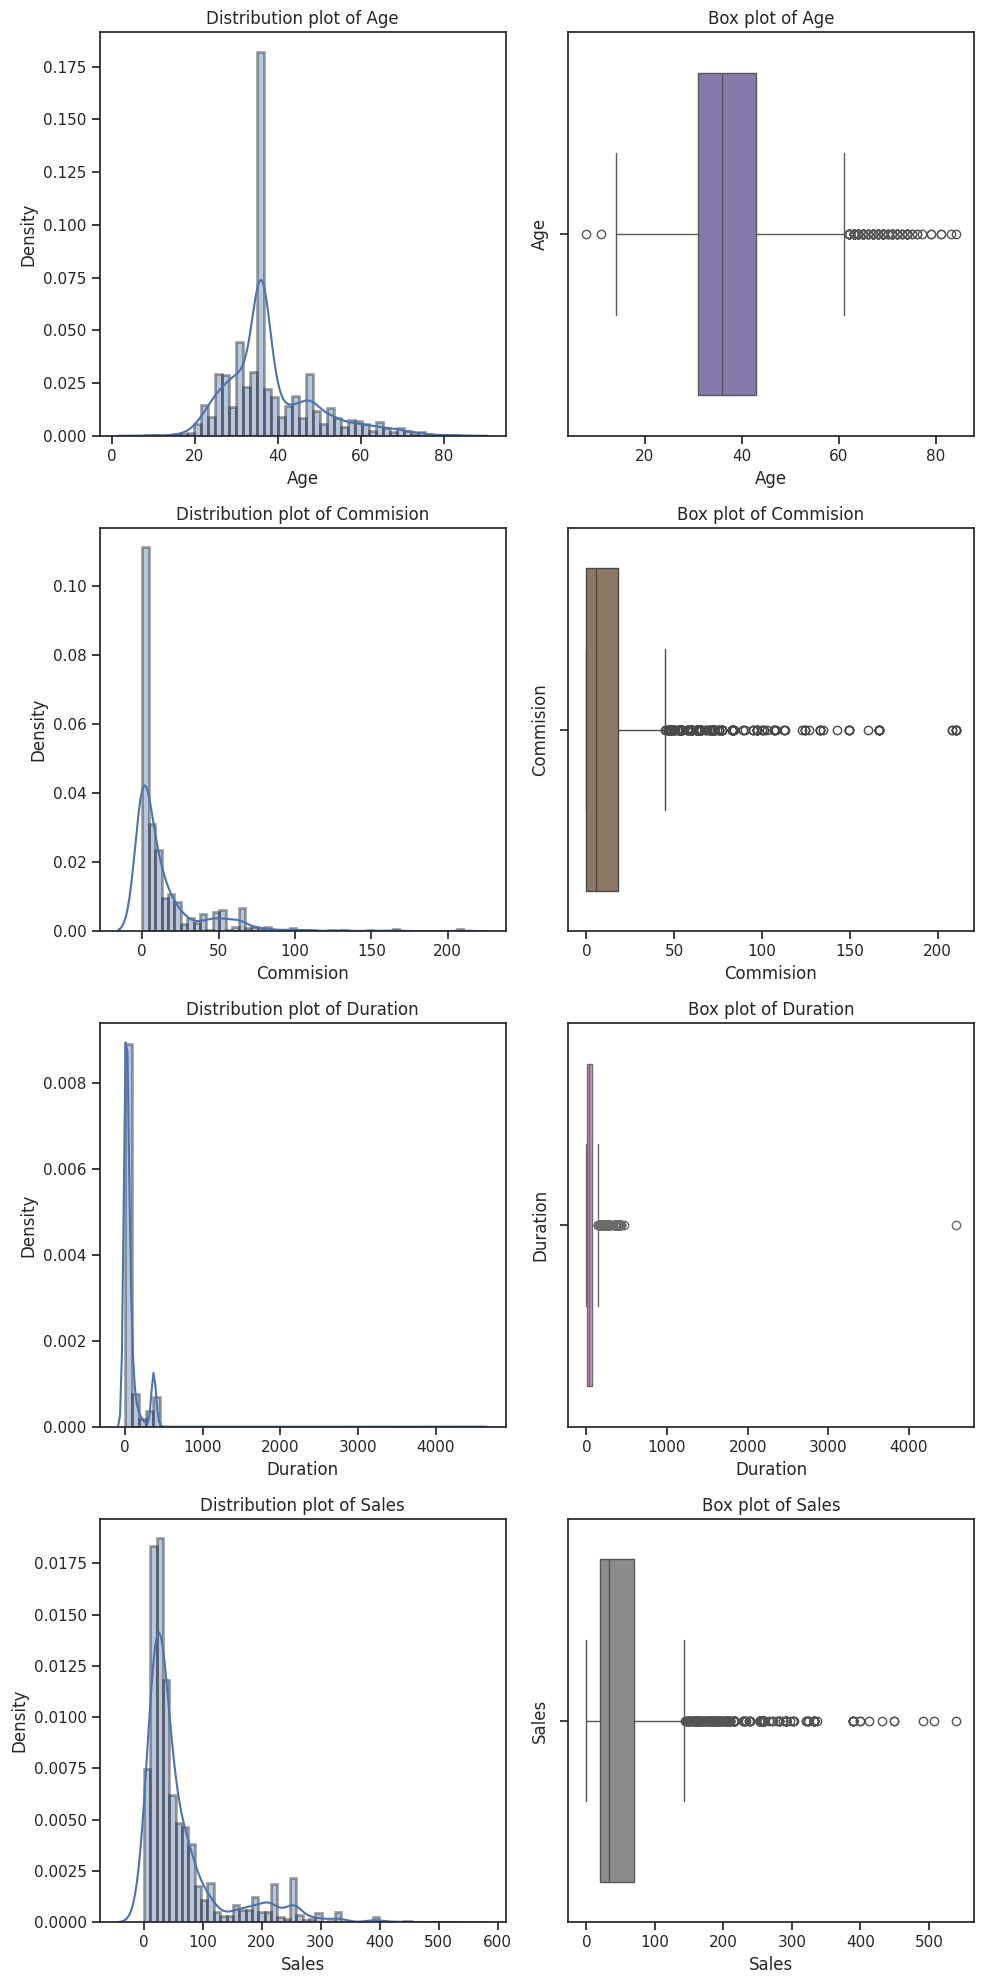

In [ ]:
# Distribution and boxplots of the variables

a = 4  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter

fig1 = plt.figure(figsize=(10,20))

for i in numeric_cols:
    plt.subplot(a, b, c)
    plt.title('Distribution plot of {}'.format(i))
    plt.xlabel(i)
    sns.distplot(insurance_df[i], hist_kws=dict(edgecolor="k", linewidth=2))
    c = c + 1

    plt.subplot(a, b, c)
    plt.title('Box plot of {}'.format(i))
    plt.ylabel(i)
    sns.boxplot(x = insurance_df[i], orient='h', palette=palette)
    c = c + 1

plt.tight_layout()
plt.show()

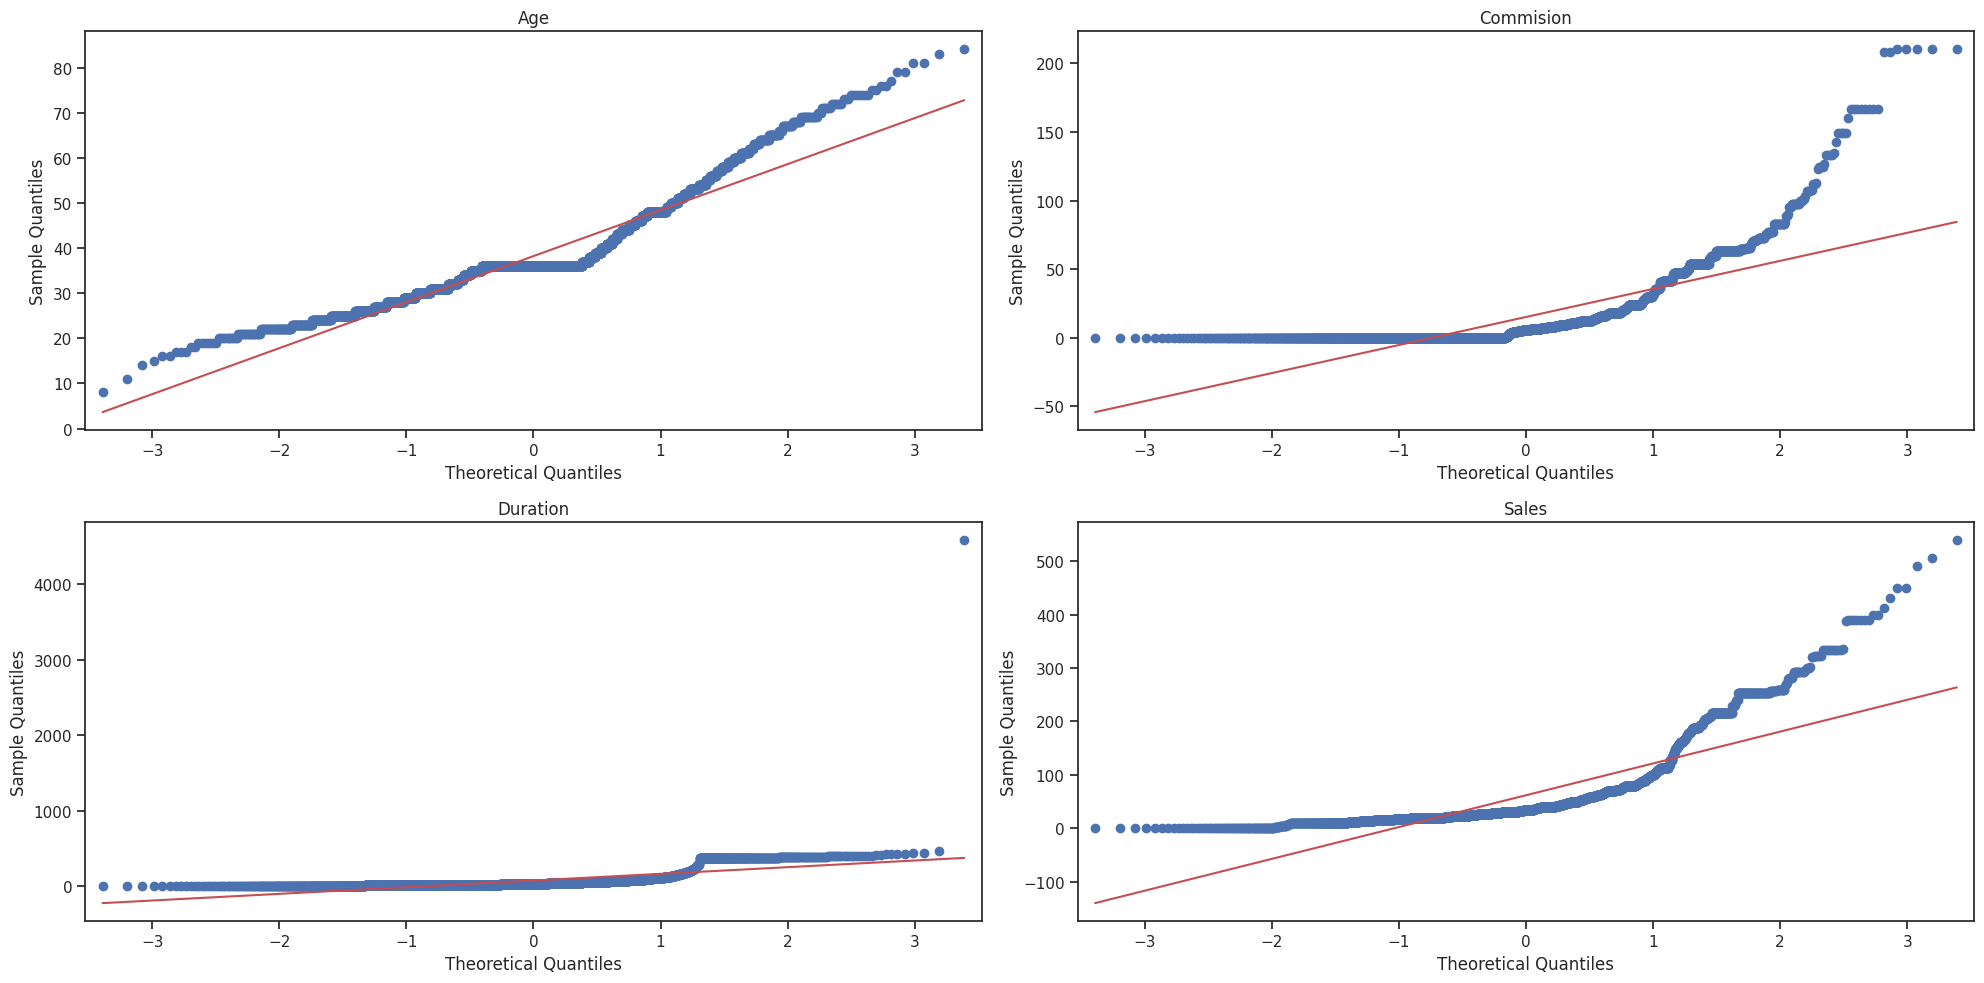

In [ ]:
# Q-Q Plots for assessing normality

# Calculate the number of rows needed for the subplots
num_rows = int(np.ceil(len(numeric_cols) / 2))

# Create a figure and axes for the subplots
fig2, axes = plt.subplots(num_rows, 2, figsize=(20, 5 * num_rows))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through the numerical columns and create Q-Q plots
for i, col in enumerate(numeric_cols):
    sm.qqplot(insurance_df[col], line='r', ax=axes[i])
    axes[i].set_title(col)

# Hide any empty subplots if the number of columns is not a multiple of 2
for i in range(len(numeric_cols), num_rows * 2):
    axes[i].set_visible(False)

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


In [ ]:
# Shapiro-Wilk test to assess normality

# Iterate through numerical columns and perform Shapiro-Wilk test
for col in numeric_cols:
    statistic, p_value = shapiro(insurance_df[col])
    print(f"Shapiro-Wilk test for {col}:")
    print(f"  Statistic: {statistic:.3f}")
    print(f"  P-value: {p_value:.3f}")
    print("-" * 20)  # Print a separator line

Shapiro-Wilk test for Age:
  Statistic: 0.908
  P-value: 0.000
--------------------
Shapiro-Wilk test for Commision:
  Statistic: 0.626
  P-value: 0.000
--------------------
Shapiro-Wilk test for Duration:
  Statistic: 0.425
  P-value: 0.000
--------------------
Shapiro-Wilk test for Sales:
  Statistic: 0.694
  P-value: 0.000
--------------------


In [ ]:
# Outlier analysis
outlier_insurance_df = detect_outliers_iqr(insurance_df, numeric_cols)
outlier_insurance_df

,% Upper Outlier,% Lower Outlier,% Total Outlier
Age,4.47,0.07,4.54
Commision,12.37,0.00,12.37
Duration,12.65,0.00,12.65
Sales,12.09,0.00,12.09


<Figure size 2000x2000 with 0 Axes>

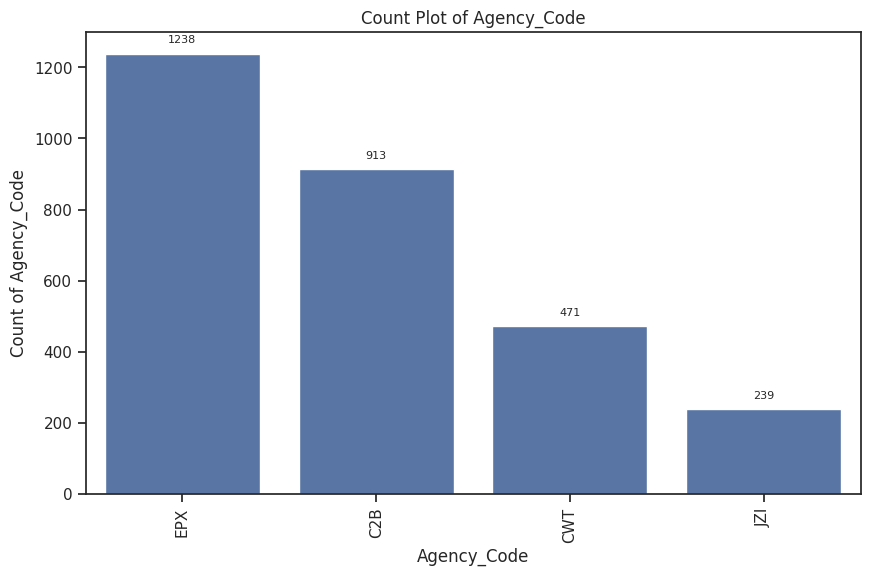

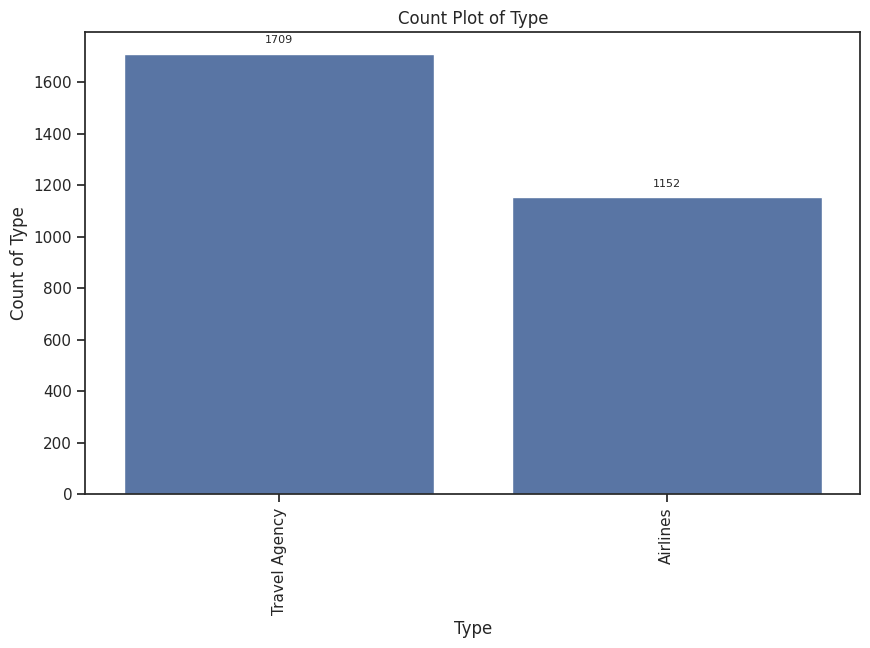

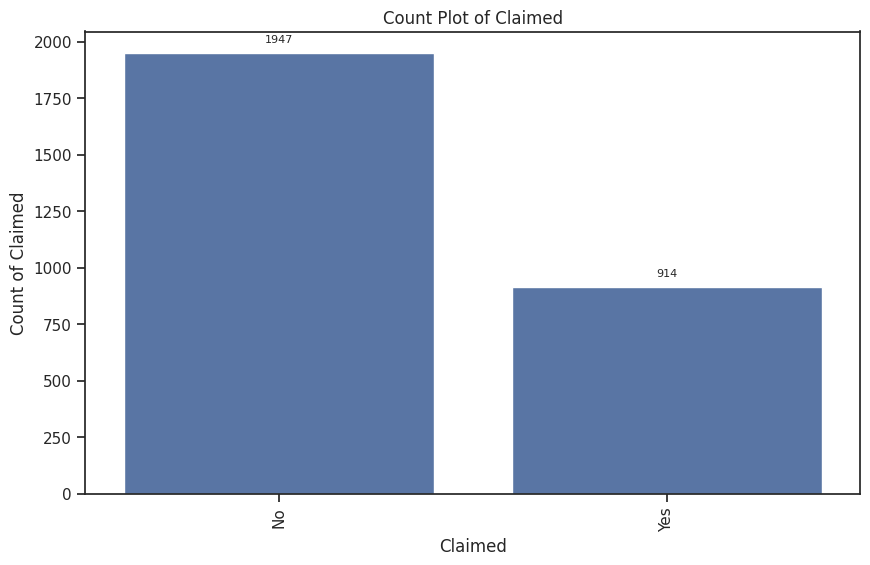

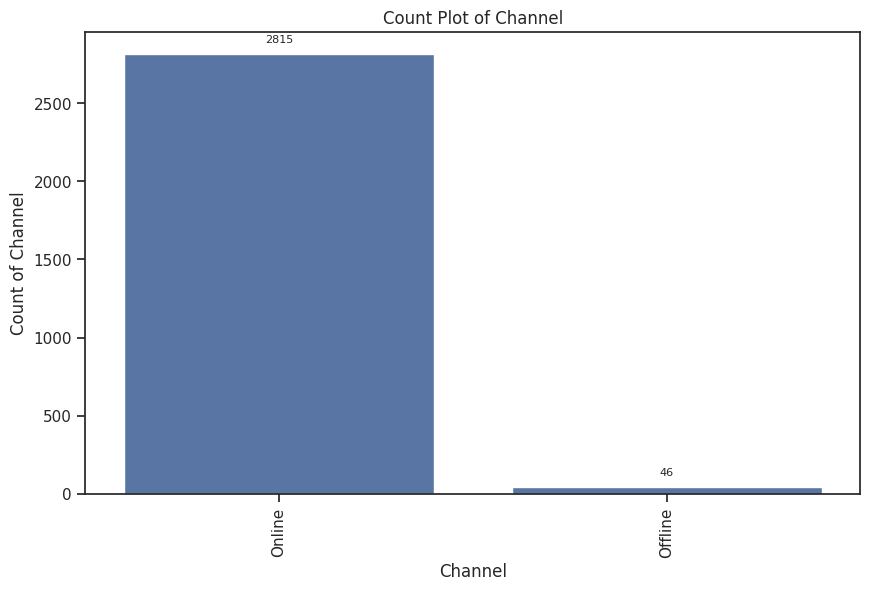

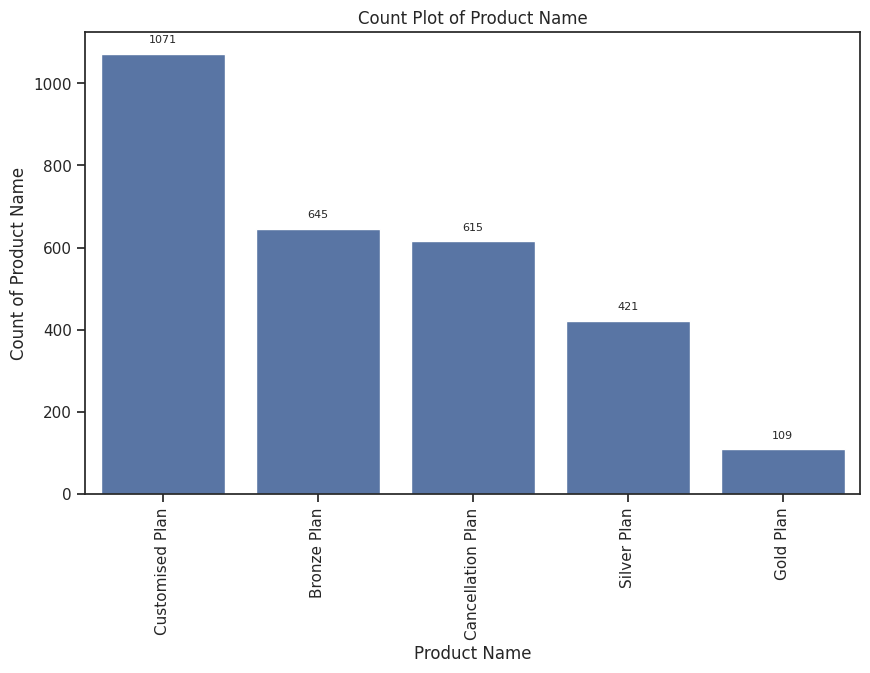

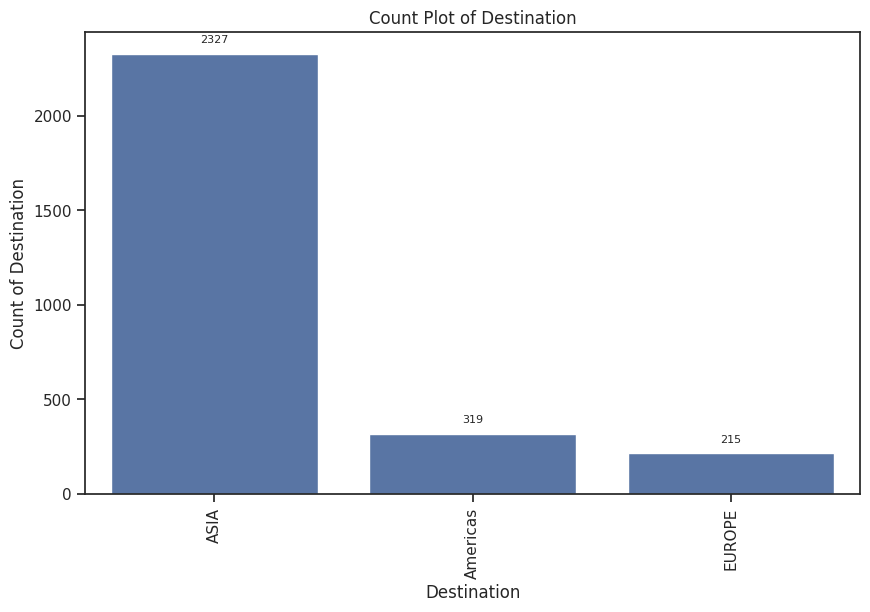

<Figure size 640x480 with 0 Axes>

In [ ]:
# Create countplots for the non-numeric columns
for i in non_numeric_cols:
  plot_countplot(insurance_df, i);
plt.tight_layout()
plt.show()

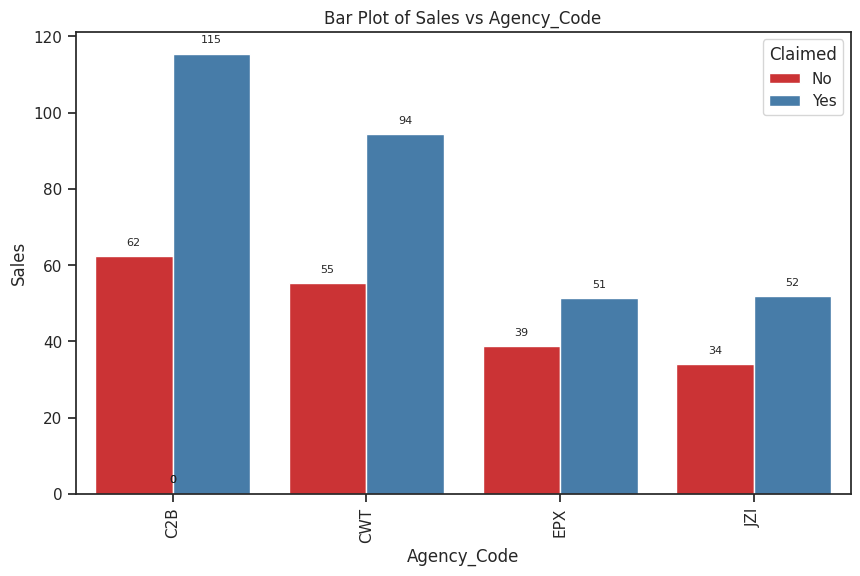

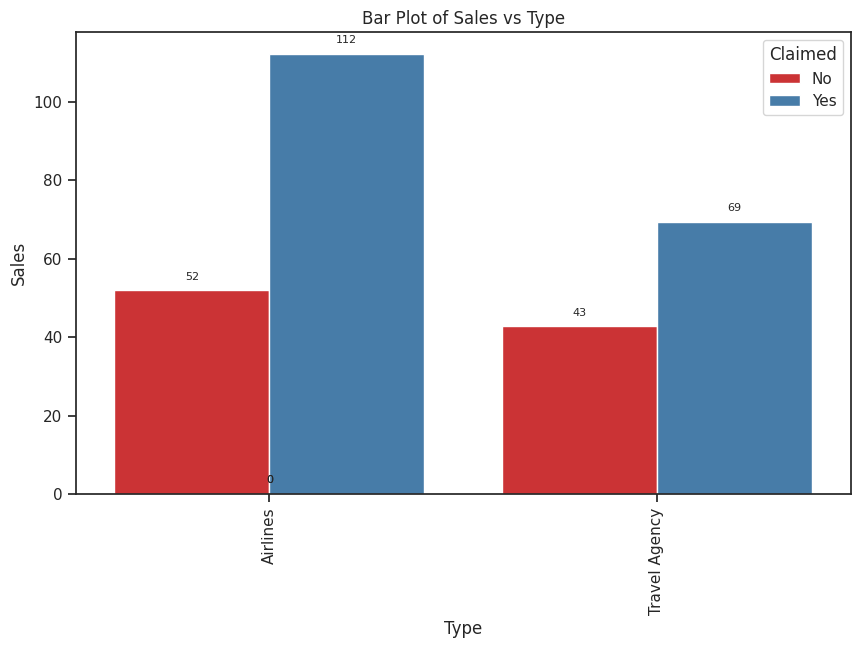

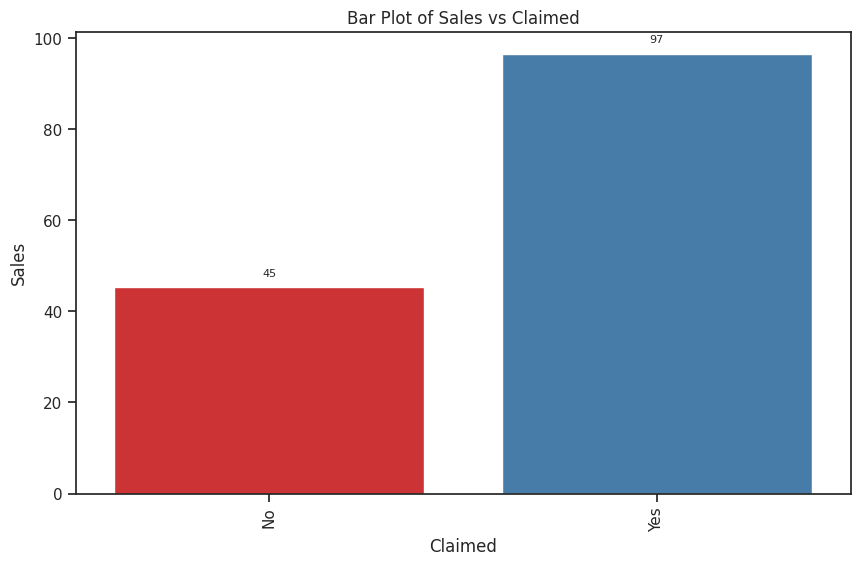

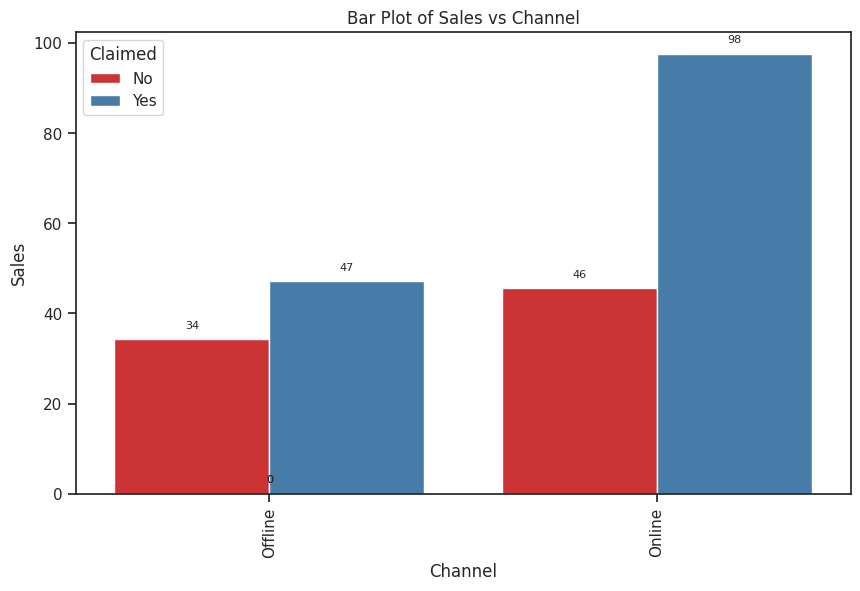

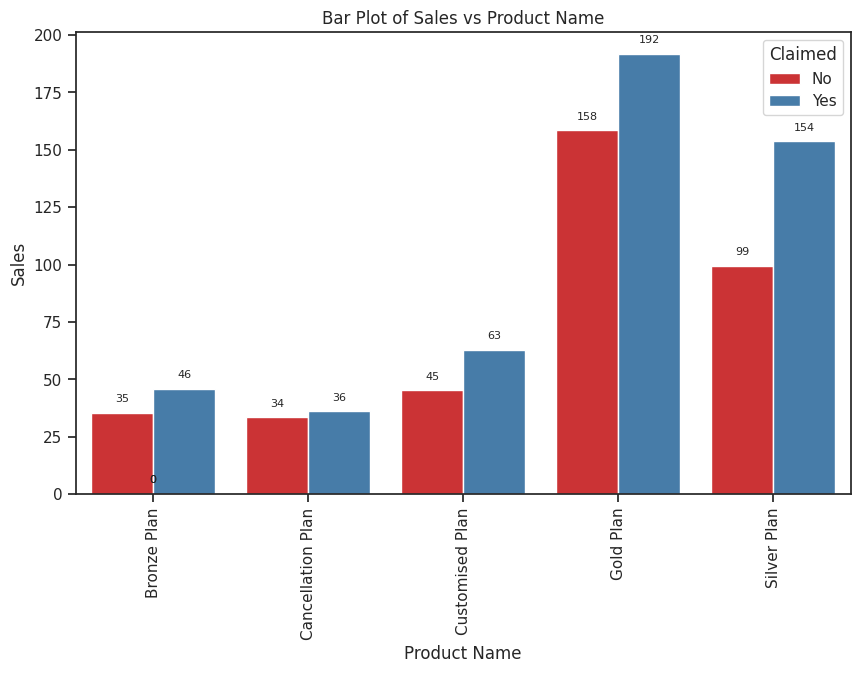

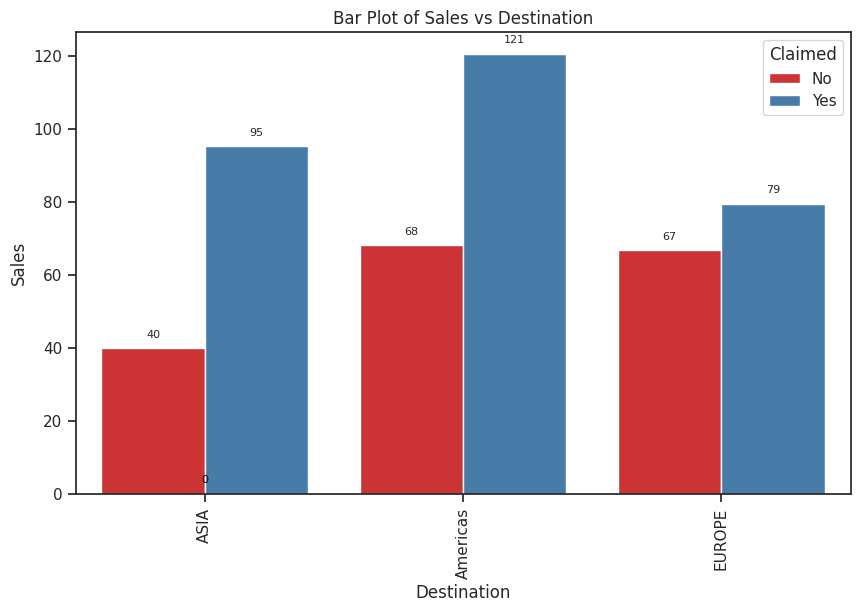

<Figure size 640x480 with 0 Axes>

In [ ]:
# Create barplots for the non-numeric columns
for i in non_numeric_cols:
  plot_barplot(insurance_df, i, 'Sales', hue='Claimed');
plt.tight_layout()
plt.show()

**Insights from Univariate Analysis**

**1. Numerical Variables**

**Duration:**

*   **Distribution:** The distribution plot shows a right-skewed distribution, indicating that most tours have shorter durations with a few outliers having longer durations. The box plot confirms this by showing several outliers beyond the upper whisker. The Q-Q plot further validates this non-normality by deviating significantly from the straight line, especially at the tails. The Shapiro-Wilk test likely resulted in a low p-value, rejecting normality.
*   **Central Tendency:** The statistical summary likely shows a higher mean than median due to the positive skew.
*   **Outliers:** Outlier analysis reveals 1.97% upper outliers, indicating some trips with unusually long durations.
*   **Insights:** Most customers prefer shorter tour durations, but there is a segment that opts for longer or custom tours, reflected by the outliers. The non-normality and outliers suggest considering data transformations or robust methods during modeling.

**Sales:**

*   **Distribution:** Similar to Duration, Sales exhibits a right-skewed distribution with most sales concentrated in a lower range and a few higher-value sales. The box plot displays outliers above the upper whisker. The Q-Q plot supports this non-normal distribution, and the Shapiro-Wilk test likely rejected normality.
*   **Central Tendency:** The mean is likely greater than the median.
*   **Outliers:** Outlier analysis shows 0.66% upper outliers for 'Sales'.
*   **Insights:** Most sales transactions involve lower-priced tour packages. Premium packages or larger group bookings contribute to higher-value sales (outliers). The non-normality and outliers suggest data transformation or robust methods for modeling.

**Commission:**

*   **Distribution:** The distribution is likely skewed, potentially depending on the commission structure. The Q-Q plot highlights deviations from normality, particularly at the upper end, and the Shapiro-Wilk test likely rejected normality.
*   **Central Tendency:** The mean and median might differ due to the skewness.
*   **Outliers:** Outlier analysis identifies 5.88% upper outliers for 'Commission'.
*   **Insights:** Commission earned varies based on sale value, product, or agency. Outliers could represent cases with higher commission rates. Non-normality and outliers need careful consideration during modeling.

**Age:**

*   **Distribution:** The distribution plot likely shows a right skew, suggesting a higher concentration of younger insured individuals. The box plot might show outliers towards older ages. The Q-Q plot reinforces the non-normal distribution, and the Shapiro-Wilk test likely rejected normality.
*   **Central Tendency:** The mean could be slightly higher than the median due to the skew.
*   **Outliers:** Outlier analysis indicates 0.08% upper outliers for 'Age'.
*   **Insights:** Most tour insurance purchases are by younger customers, but a smaller segment consists of older travelers. Non-normality and outliers require potential data transformation or specific outlier handling.


**2. Categorical Variables**

**1. Agency_Code:**

*   **Count Plot:** The count plot reveals that 'EPX' is the most frequent agency, followed by 'C2B' and 'JZI'. This suggests that a large portion of tour insurance sales are handled through these agencies.
*   **Bar Plot:** The bar plot displays the average sales for each agency, categorized by 'Claimed' status (Yes/No). Key observations include:
    *   Agency 'CWT' has the highest average sales, followed by 'EPX'. However, 'CWT' has a relatively lower count in the count plot, suggesting it handles fewer sales but with higher value.
    *   Agencies 'ART' and 'CCR' have relatively higher average sales for claimed cases compared to non-claimed cases, indicating a potential higher claim frequency or higher-value claims associated with these agencies.
*   **Insights:**
    *   The top agencies in terms of sales frequency are 'EPX', 'C2B', and 'JZI'. However, 'CWT' handles higher-value sales despite its lower frequency.
    *   Agencies 'ART' and 'CCR' might need attention due to their higher average sales for claimed cases, suggesting a higher claim risk associated with these agencies.

**2. Type:**

*   **Count Plot:** The count plot for 'Type' shows that 'Travel Agency' is the most frequent type of insurance firm, followed by 'Airlines'. This indicates that most tour insurance policies are sold through travel agencies and airlines.
*   **Bar Plot:** The bar plot for 'Type' reveals that:
    *   'Airlines' have the highest average sales, followed by 'Travel Agency'.
    *   Both 'Airlines' and 'Travel Agency' have a slightly higher average sales for claimed cases compared to non-claimed cases, suggesting a potential difference in claim patterns between these types of firms.
*   **Insights:**
    *   Travel agencies handle the largest volume of sales, followed by airlines.
    *   Airlines have higher average sales than travel agencies.
    *   There might be a slight difference in claim frequency or claim amounts between 'Airlines' and 'Travel Agency' types, as indicated by the bar plot.

**3. Channel:**

*   **Count Plot:** The count plot for 'Channel' shows that 'Online' is the most frequent sales channel.
*   **Bar Plot:** The bar plot for 'Channel' reveals that:
    *   'Offline' has a significantly higher average sales compared to 'Online'.
    *   'Offline' also has a much higher average sales for claimed cases than non-claimed cases, suggesting a potentially higher claim frequency or higher claim value for sales made through the 'Offline' channel.
*   **Insights:**
    *   While online sales are more frequent, offline sales generate higher average sales values.
    *   The 'Offline' channel might need closer monitoring due to the higher average sales for claimed cases, indicating a potential higher claim risk associated with this channel.

**4. Product Name:**

*   **Count Plot:** The count plot for 'Product Name' reveals that 'Cancellation Plan' is the most frequently sold product, followed by 'Bronze Plan' and 'Silver Plan'.
*   **Bar Plot:** The bar plot for 'Product Name' shows that:
    *   'Gold Plan' has the highest average sales, followed by 'Silver Plan'. These plans likely represent more comprehensive or premium insurance options.
    *   'Gold Plan' and 'Silver Plan' also have noticeably higher average sales for claimed cases compared to non-claimed cases, potentially indicating higher claim frequency or value for these plans.
*   **Insights:**
    *   The most popular products are 'Cancellation Plan', 'Bronze Plan', and 'Silver Plan'.
    *   'Gold Plan' and 'Silver Plan' are the premium offerings and generate higher average sales.
    *   'Gold Plan' and 'Silver Plan' might carry a higher claim risk as evident from the higher average sales for claimed cases.

**5. Destination:**

*   **Count Plot:** The count plot for 'Destination' shows that 'SINGAPORE' is the most frequent destination for insured trips, followed by 'MALAYSIA'.
*   **Bar Plot:** The bar plot for 'Destination' reveals that:
    *   'UNITED STATES' has the highest average sales, followed by 'AUSTRALIA'. These destinations likely involve longer trips or higher travel costs, leading to higher insurance premiums.
    *   'UNITED STATES' also has a significantly higher average sales for claimed cases compared to non-claimed cases, potentially suggesting a higher claim frequency or value for this destination.
*   **Insights:**
    *   The most popular travel destinations are 'SINGAPORE' and 'MALAYSIA'.
    *   Travel insurance policies sold for 'UNITED STATES' and 'AUSTRALIA' generate higher average sales values.
    *   Trips to 'UNITED STATES' might have a higher claim risk as indicated by the higher average sales for claimed cases.

**Overall Insights:**

The univariate analysis of numerical variables (Duration, Sales, Commission, Age) reveals key insights regarding their distributions, central tendencies, and presence of outliers. These insights are crucial for understanding the data's characteristics and guiding further analysis and modeling.

Key Observations:

Non-Normality: All four numerical variables exhibit non-normal distributions, primarily characterized by right-skewness. This indicates a higher concentration of values in the lower range with a few extreme values extending towards the higher end. This non-normality is evident from the distribution plots, Q-Q plots, and the likely rejection of normality by the Shapiro-Wilk test.

Skewness and Central Tendency: The right-skewness in the distributions influences the central tendency measures. In most cases, the mean is likely higher than the median due to the presence of outliers or extreme values pulling the mean towards the higher end.

Outliers: Outlier analysis identifies the presence of upper outliers for all numerical variables, albeit with varying percentages. These outliers represent data points significantly deviating from the majority of the data. Duration and Commission exhibit a relatively higher percentage of outliers compared to Sales and Age.

Business Implications:

Duration: Most customers opt for shorter tour durations, while a smaller segment prefers longer or custom tours.
Sales: The majority of sales involve lower-priced tour packages, with premium packages or group bookings contributing to higher-value sales (outliers).
Commission: Commission earned varies depending on factors like sales value, product, or agency, with outliers potentially representing cases with higher commission rates.
Age: Most tour insurance purchases are made by younger individuals, with a smaller segment comprising older travelers.
Modeling Considerations:

Data Transformation: The non-normality of the numerical variables suggests considering data transformations (e.g., logarithmic transformation) to improve model performance.
Robust Methods: Robust statistical methods or models less sensitive to outliers might be preferred for analysis and prediction.
Outlier Handling: Specific outlier handling techniques, such as winsorization or capping, could be considered to mitigate the impact of extreme values on model results.

#### **4d. Bi-Variate Analysis**

<Figure size 2000x1000 with 0 Axes>

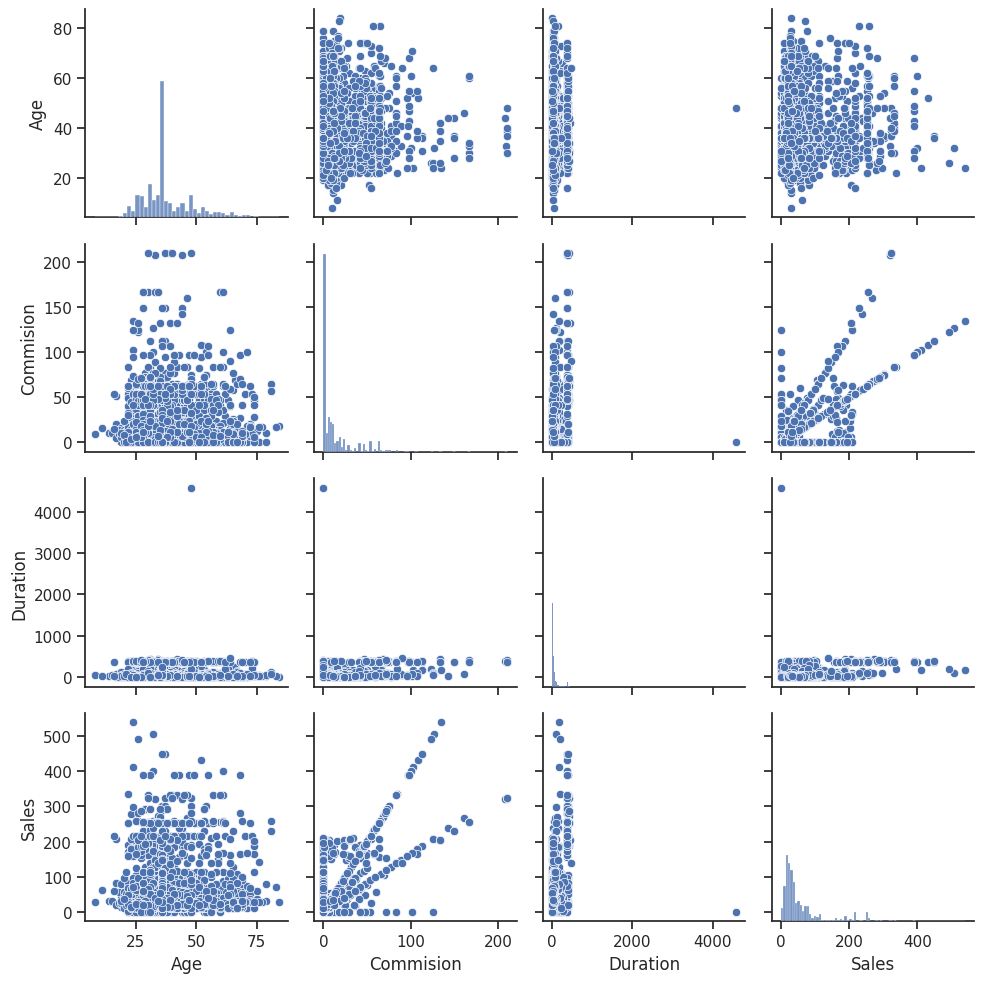

In [ ]:
# Pair plot of the numerical variables
fig3 = plt.figure(figsize=(20,10))
sns.pairplot(data=insurance_df[numeric_cols], palette='Set2')
plt.tight_layout()
plt.show()

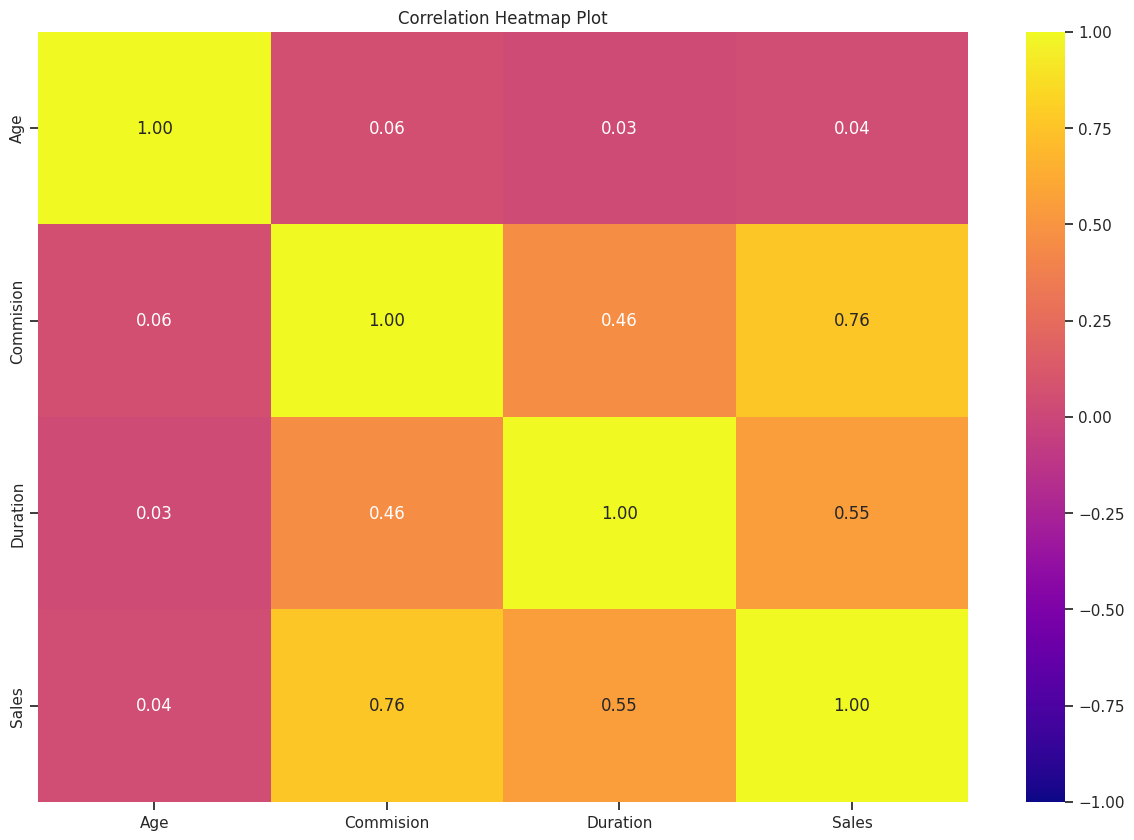

In [ ]:
# Plot correlation heatmap
plt.figure(figsize=(15,10))
sns.heatmap(round(insurance_df[numeric_cols].corr(),2),fmt='.2f',annot=True,cmap='plasma', vmin=-1, vmax=1,)
plt.title('Correlation Heatmap Plot')
plt.show()

**Insights from Bivariate Analysis**

The bivariate analysis, primarily using pair plots and a correlation heatmap, provides insights into the relationships between numerical variables in the insurance dataset.

**Key Observations:**

1. **Pair Plots:** The pair plots visually depict the relationships between pairs of numerical variables through scatter plots. We can observe the following:
    * **Duration and Sales:** There is a slight positive correlation between Duration and Sales, indicating that longer trips tend to have higher sales values. However, the relationship is not very strong and there is considerable scatter in the data points.
    * **Duration and Commission:** A moderate positive correlation exists between Duration and Commission, suggesting that longer trips generally result in higher commissions.
    * **Sales and Commission:** A strong positive correlation is observed between Sales and Commission, indicating that higher sales values are associated with higher commission earnings. This relationship is expected as commission is typically a percentage of sales.
    * **Age and Other Variables:** Age does not exhibit a strong correlation with any other numerical variable, suggesting that age might not be a major driver of sales, duration, or commission.

2. **Correlation Heatmap:** The correlation heatmap quantifies the linear relationships between numerical variables using correlation coefficients. The heatmap supports the observations from pair plots and reveals:
    * **Strongest Correlation:** Sales and Commission have the strongest positive correlation (close to 1), as expected.
    * **Moderate Correlation:** Duration and Sales, and Duration and Commission show moderate positive correlations.
    * **Weak Correlation:** Age has weak correlations with other variables, indicating its limited influence on these factors.

**Insights and Business Implications:**

* **Duration and Sales:** The positive correlation between Duration and Sales suggests that customers opting for longer trips tend to spend more on insurance policies. This could be due to higher travel costs or a greater need for coverage during extended trips.
* **Commission Structure:** The strong correlation between Sales and Commission highlights the commission structure, where higher sales lead to higher commission earnings. This is expected and is likely based on a percentage-based commission model.
* **Age as a Factor:** Age does not appear to be a major driver of sales, duration, or commission. This indicates that tour insurance purchases are likely made by customers across a wide range of ages.
* **Product or Agency Impact:** The lack of strong correlations between Age and other variables suggests that other factors like agency practices, product types, or destination preferences might be more significant determinants of insurance purchase decisions.

**Recommendations for Further Analysis:**

* **Explore Interactions:** Further investigation into potential interactions between numerical and categorical variables is recommended to gain a more comprehensive understanding of factors influencing claim status.
* **Consider Data Transformation:** The non-normality of the numerical variables observed in the univariate analysis suggests exploring data transformations to potentially strengthen linear relationships and improve model performance.
* **Focus on Key Correlations:** The strong correlation between Sales and Commission highlights its potential importance in predicting claim risk. This relationship should be carefully considered when building predictive models.
* **Segment Customer Groups:** Analyzing the data for specific customer segments based on age, agency, or product types can reveal more detailed insights and uncover patterns within those groups.

 ### **5. Model Building**

#### **5a. One-Hot encoding of the object datatypes**

In [ ]:
for feature in insurance_df.columns:
    if insurance_df[feature].dtype == 'object':
        print('\n')
        print('Feature:',feature)
        print(pd.Categorical(insurance_df[feature].unique()))
        print(pd.Categorical(insurance_df[feature].unique()).codes)
        insurance_df[feature] = pd.Categorical(insurance_df[feature]).codes



Feature: Agency_Code
['C2B', 'EPX', 'CWT', 'JZI']
Categories (4, object): ['C2B', 'CWT', 'EPX', 'JZI']
[0 2 1 3]


Feature: Type
['Airlines', 'Travel Agency']
Categories (2, object): ['Airlines', 'Travel Agency']
[0 1]


Feature: Claimed
['No', 'Yes']
Categories (2, object): ['No', 'Yes']
[0 1]


Feature: Channel
['Online', 'Offline']
Categories (2, object): ['Offline', 'Online']
[1 0]


Feature: Product Name
['Customised Plan', 'Cancellation Plan', 'Bronze Plan', 'Silver Plan', 'Gold Plan']
Categories (5, object): ['Bronze Plan', 'Cancellation Plan', 'Customised Plan', 'Gold Plan',
                         'Silver Plan']
[2 1 0 4 3]


Feature: Destination
['ASIA', 'Americas', 'EUROPE']
Categories (3, object): ['ASIA', 'Americas', 'EUROPE']
[0 1 2]


In [ ]:
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2861 entries, 0 to 2860
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Age           2861 non-null   int64  
 1   Agency_Code   2861 non-null   int8   
 2   Type          2861 non-null   int8   
 3   Claimed       2861 non-null   int8   
 4   Commision     2861 non-null   float64
 5   Channel       2861 non-null   int8   
 6   Duration      2861 non-null   int64  
 7   Sales         2861 non-null   float64
 8   Product Name  2861 non-null   int8   
 9   Destination   2861 non-null   int8   
dtypes: float64(2), int64(2), int8(6)
memory usage: 106.3 KB


In [ ]:
insurance_df.head()

,Age,Agency_Code,Type,Claimed,Commision,Channel,Duration,Sales,Product Name,Destination
0,48,0,0,0,0.70,1,7,2.51,2,0
1,36,2,1,0,0.00,1,34,20.00,2,0
2,39,1,1,0,5.94,1,3,9.90,2,1
3,36,2,1,0,0.00,1,4,26.00,1,0
4,33,3,0,0,6.30,1,53,18.00,0,0


### **5b. Train-Test Split**

In [ ]:
X = insurance_df.drop("Claimed", axis=1)
y = insurance_df.pop("Claimed")
X.head()

,Age,Agency_Code,Type,Commision,Channel,Duration,Sales,Product Name,Destination
0,48,0,0,0.70,1,7,2.51,2,0
1,36,2,1,0.00,1,34,20.00,2,0
2,39,1,1,5.94,1,3,9.90,2,1
3,36,2,1,0.00,1,4,26.00,1,0
4,33,3,0,6.30,1,53,18.00,0,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=1)

In [ ]:
print('X_train',X_train.shape)
print('X_test',X_test.shape)
print('train_labels',y_train.shape)
print('test_labels',y_test.shape)

X_train (2002, 9)
X_test (859, 9)
train_labels (2002,)
test_labels (859,)


In [ ]:
sc=StandardScaler()

In [ ]:
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

#### **5c. Model Instantiation**

In [ ]:
# Instantiate the CART model

clfdtc = DecisionTreeClassifier(random_state=1)

# Instantiate the RFC Model

clfrfc = RandomForestClassifier(random_state=1)

# Instantiate the MLP Model

clfmlp = MLPClassifier(random_state=1)

In [ ]:
model_names = {clfdtc:'Decision Tree Classifier', clfrfc:'Random Forest Classifier', clfmlp:'Multilayer Perceptron'}


In [ ]:
# Custom Function after grid search

def grid_model_func(model, best_grid_estimator, x_train, x_test, Y_train, Y_test):

  # Predict on both train and test set
  Y_train_predict = best_grid_estimator.predict(x_train)
  Y_test_predict = best_grid_estimator.predict(x_test)

  # Print classification report for the training data
  print('Classification report for the {} model after grid search on the training set is'.format(model_names[model]),'\n',classification_report(Y_train,Y_train_predict))

  # Display the confusion matrix for the train data
  sns.heatmap(confusion_matrix(Y_train,Y_train_predict),annot=True,fmt='d',cbar=False, cmap='plasma')
  plt.title('Confusion Matrix for the {} model after grid search on the training set'.format(model_names[model]))
  plt.xlabel('Predicted Label')
  plt.ylabel('Actual Label')
  plt.show()

  # Display the ROC-AUC curve for the train data
  fpr_train, tpr_train, thresholds = roc_curve(Y_train,best_grid_estimator.predict_proba(x_train)[:,1])
  plt.plot(fpr_train, tpr_train, marker='.')
  plt.plot([0, 1], [0, 1], linestyle='--')

  plt.title('ROC Curve for the {} model after grid search on the training set'.format(model_names[model]))
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.legend(['{}_train_GS'.format(model_names[model])], loc='best')
  plt.show()

  print('\n')

  # Evaluate the performance metrics on the train set

  acc_train = accuracy_score(Y_train,Y_train_predict)
  roc_train = roc_auc_score(Y_train,best_grid_estimator.predict_proba(x_train)[:,1])
  precision_train = precision_score(Y_train,Y_train_predict)
  recall_train = recall_score(Y_train,Y_train_predict)
  f1_train = f1_score(Y_train,Y_train_predict)
  train_scores = cross_val_score(best_grid_estimator, x_train, Y_train, cv=10)
  mean_cv_score_train = np.mean(train_scores)

  print('############################################Testing Set################################################', '\n')

  # Print classification report for the testing data
  print('Classification report for the {} model after grid search on the testing set is'.format(model_names[model]),'\n',classification_report(Y_test,Y_test_predict))

  # Display the confusion matrix for the test data
  sns.heatmap(confusion_matrix(Y_test,Y_test_predict),annot=True,fmt='d',cbar=False, cmap='summer')
  plt.title('Confusion Matrix for the {} model after grid search on the testing set'.format(model_names[model]))
  plt.xlabel('Predicted Label')
  plt.ylabel('Actual Label')
  plt.show()

  # Display the ROC-AUC curve for the test data
  fpr_test, tpr_test, thresholds = roc_curve(Y_test,best_grid_estimator.predict_proba(x_test)[:,1])
  plt.plot(fpr_test, tpr_test, marker='*')
  plt.plot([0, 1], [0, 1], linestyle='--')

  plt.title('ROC Curve for the {} model after grid search on the testing set'.format(model_names[model]))
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.legend(['{}_test_GS'.format(model_names[model])], loc='best')
  plt.show()

  print('\n')

  # Evaluate the performance metrics on the test set
  acc_test = accuracy_score(Y_test,Y_test_predict)
  roc_test = roc_auc_score(Y_test,best_grid_estimator.predict_proba(x_test)[:,1])
  precision_test = precision_score(Y_test,Y_test_predict)
  recall_test = recall_score(Y_test,Y_test_predict)
  f1_test = f1_score(Y_test,Y_test_predict)
  test_scores = cross_val_score(best_grid_estimator, x_test, Y_test, cv=10)
  mean_cv_score_test = np.mean(test_scores)

  # Display the performance metrics in a dataframe
  index=['Accuracy', 'ROC-AUC', 'Precision', 'Recall', 'F1-Score', 'Mean_CV_Score']
  data = pd.DataFrame({'Train':[acc_train, roc_train, precision_train, recall_train, f1_train, mean_cv_score_train],
                       'Test':[acc_test, roc_test, precision_test, recall_test, f1_test, mean_cv_score_test]},
                      index=index)
  round(data,3)
  print('The performance metrics for the {} model after grid search'.format(model_names[model]))
  return data.T


In [ ]:
# Custom function for getting best estimator

def grid (model, parameter_grid, X, Y, CV=1):
  param_grid = parameter_grid

  grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = CV, n_jobs=-1)

  #Fit the model on the training data
  grid_search.fit(X, Y)

  #Print the best parameters after grid search
  grid_search.best_params_

  print(grid_search.best_params_)

  # Create the best grid estimator
  best_grid_estimator = grid_search.best_estimator_

  return best_grid_estimator

#### **5d. Parameter Grid**

In [ ]:
# Perform grid search of best parameters for CART

param_grid_dtc = {
    'criterion': ['gini'],
    'max_depth': [10,20,30,50],
    'min_samples_leaf': [50,100,150,200],
    'min_samples_split': [150,300,450,500],
}

# Perform Grid Search of best parameters for RFC

param_grid_rfc = {
    'max_depth': [5, 10, 15],
    'max_features': [3, 4, 5, 6],
    'min_samples_leaf': [25, 50, 100],
    'min_samples_split': [150, 300, 450],
    'n_estimators': [100, 200, 300]
}

param_grid_mlp = {
    'hidden_layer_sizes': [50,100,200], # 50, 200
    'max_iter': [2500,3000,4000], #5000,2500
    'solver': ['adam', 'sgd'], #sgd
    'tol': [0.01],
}

#### **5f. Decision Tree Classifier**

In [ ]:
best_grid_estimator_dtc = grid(clfdtc, param_grid_dtc, X_train, y_train, CV=5)

{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 300}


Classification report for the Decision Tree Classifier model after grid search on the training set is 
               precision    recall  f1-score   support

           0       0.81      0.85      0.83      1359
           1       0.65      0.58      0.61       643

    accuracy                           0.76      2002
   macro avg       0.73      0.72      0.72      2002
weighted avg       0.76      0.76      0.76      2002



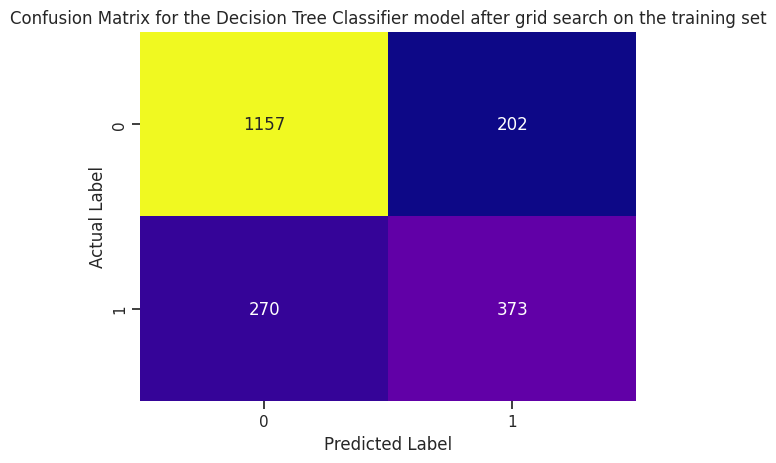

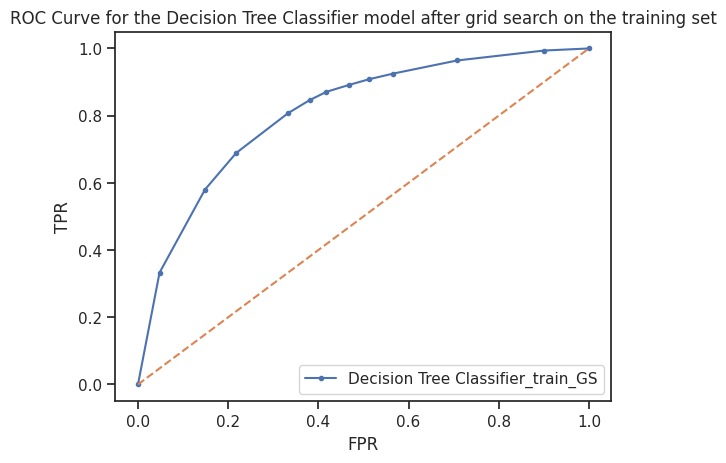



############################################Testing Set################################################ 

Classification report for the Decision Tree Classifier model after grid search on the testing set is 
               precision    recall  f1-score   support

           0       0.82      0.87      0.85       588
           1       0.68      0.60      0.63       271

    accuracy                           0.78       859
   macro avg       0.75      0.73      0.74       859
weighted avg       0.78      0.78      0.78       859



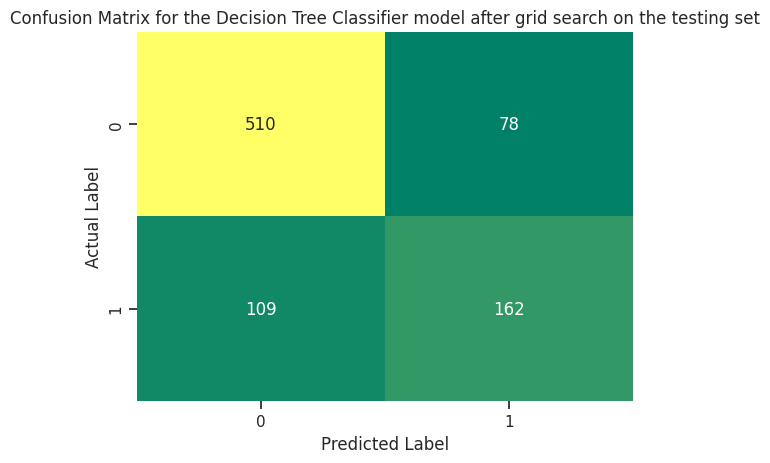

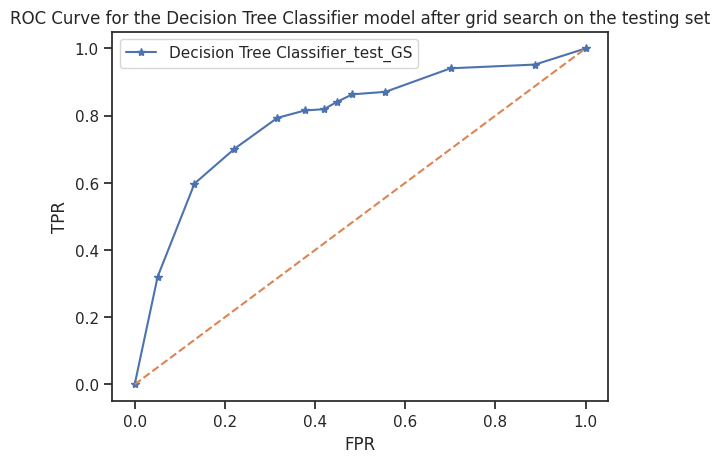



The performance metrics for the Decision Tree Classifier model after grid search


,Accuracy,ROC-AUC,Precision,Recall,F1-Score,Mean_CV_Score
Train,0.764236,0.810475,0.648696,0.580093,0.612479,0.764229
Test,0.782305,0.792279,0.675000,0.597786,0.634051,0.765978


In [ ]:
grid_model_func(clfdtc, best_grid_estimator_dtc, X_train, X_test, y_train, y_test)

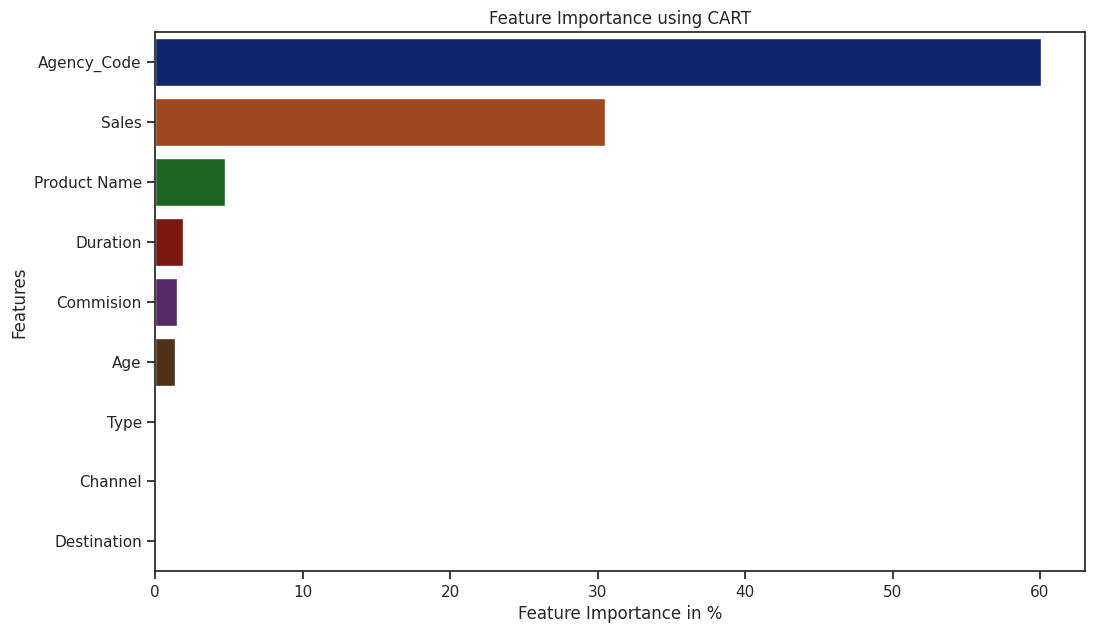

In [ ]:
x=pd.DataFrame(best_grid_estimator_dtc.feature_importances_*100,index=insurance_df.columns).sort_values(by=0,ascending=False)
plt.figure(figsize=(12,7))
sns.barplot(x=x[0], y=x.index, palette='dark', orient='h')
plt.xlabel('Feature Importance in %')
plt.ylabel('Features')
plt.title('Feature Importance using CART')
plt.show()

In [ ]:
train_char_label = ['no', 'yes']
tree_regularized = open('tree_regularized.dot','w')
dot_data = tree.export_graphviz(best_grid_estimator_dtc, out_file= tree_regularized ,
                                feature_names = list(insurance_df.columns),
                                class_names = list(train_char_label))

tree_regularized.close()
dot_data

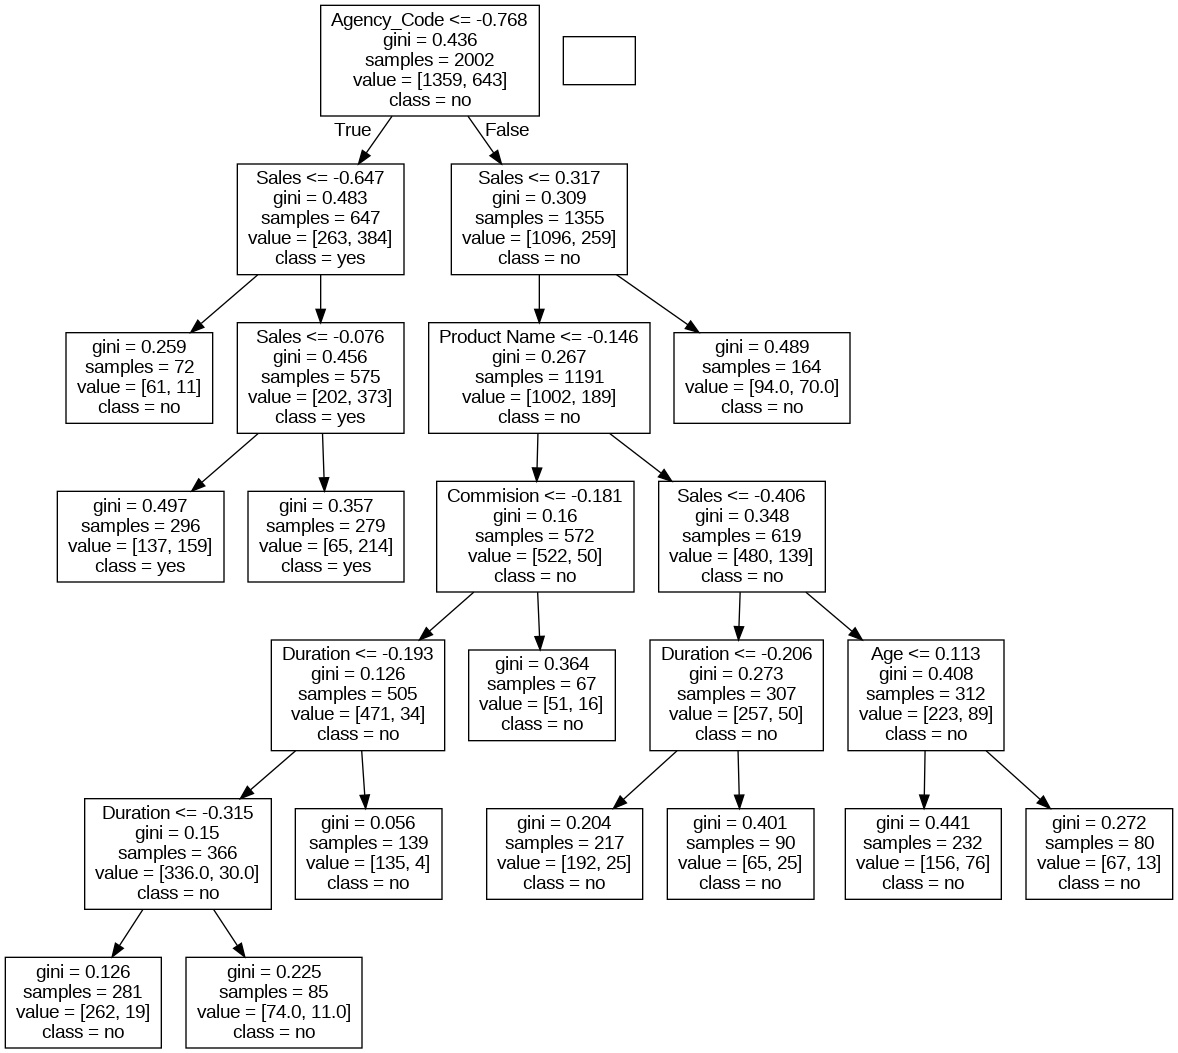

In [ ]:
graph = pydotplus.graph_from_dot_file('tree_regularized.dot')
Image(graph.create_png())

#### **5g.Random Forest Classifier**

In [ ]:
best_grid_estimator_rfc = grid(clfrfc, param_grid_rfc, X_train, y_train, CV=5)

{'max_depth': 5, 'max_features': 6, 'min_samples_leaf': 25, 'min_samples_split': 150, 'n_estimators': 100}


Classification report for the Random Forest Classifier model after grid search on the training set is 
               precision    recall  f1-score   support

           0       0.81      0.88      0.84      1359
           1       0.69      0.55      0.61       643

    accuracy                           0.78      2002
   macro avg       0.75      0.72      0.73      2002
weighted avg       0.77      0.78      0.77      2002



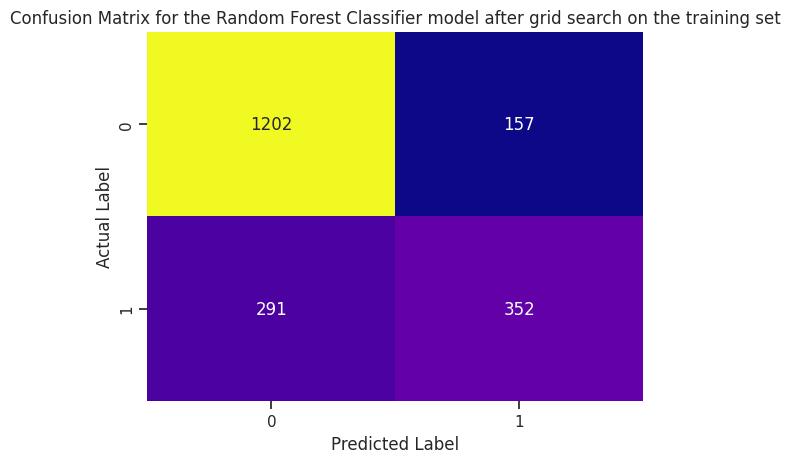

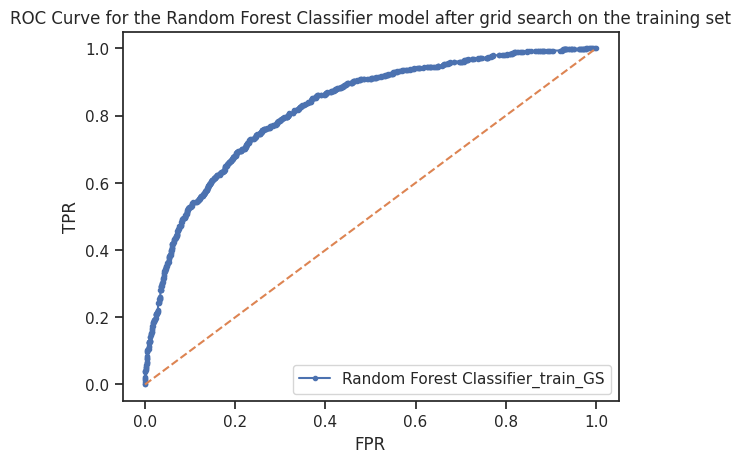



############################################Testing Set################################################ 

Classification report for the Random Forest Classifier model after grid search on the testing set is 
               precision    recall  f1-score   support

           0       0.81      0.89      0.85       588
           1       0.69      0.55      0.61       271

    accuracy                           0.78       859
   macro avg       0.75      0.72      0.73       859
weighted avg       0.77      0.78      0.77       859



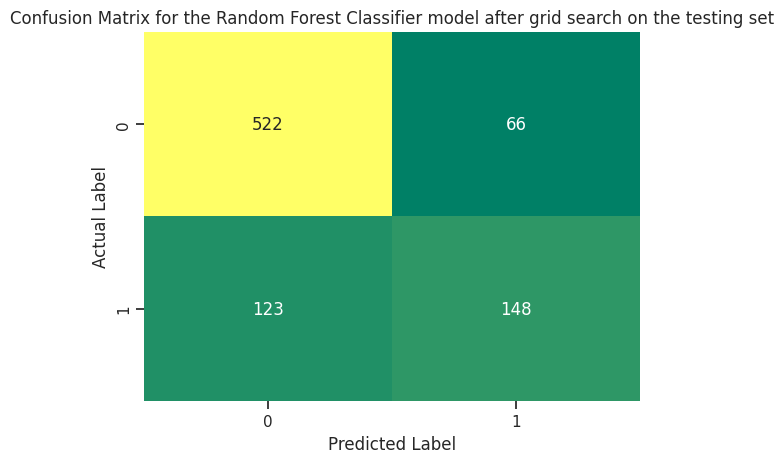

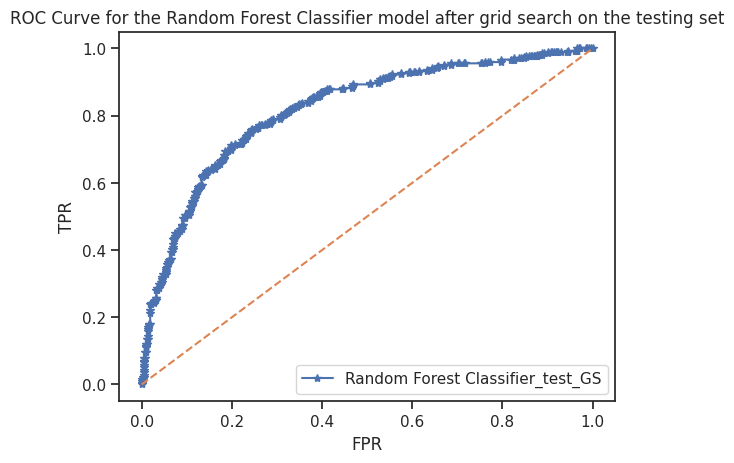



The performance metrics for the Random Forest Classifier model after grid search


,Accuracy,ROC-AUC,Precision,Recall,F1-Score,Mean_CV_Score
Train,0.776224,0.823620,0.691552,0.547434,0.611111,0.764234
Test,0.779977,0.819119,0.691589,0.546125,0.610309,0.764815


In [ ]:
grid_model_func(clfrfc, best_grid_estimator_rfc, X_train, X_test, y_train, y_test)

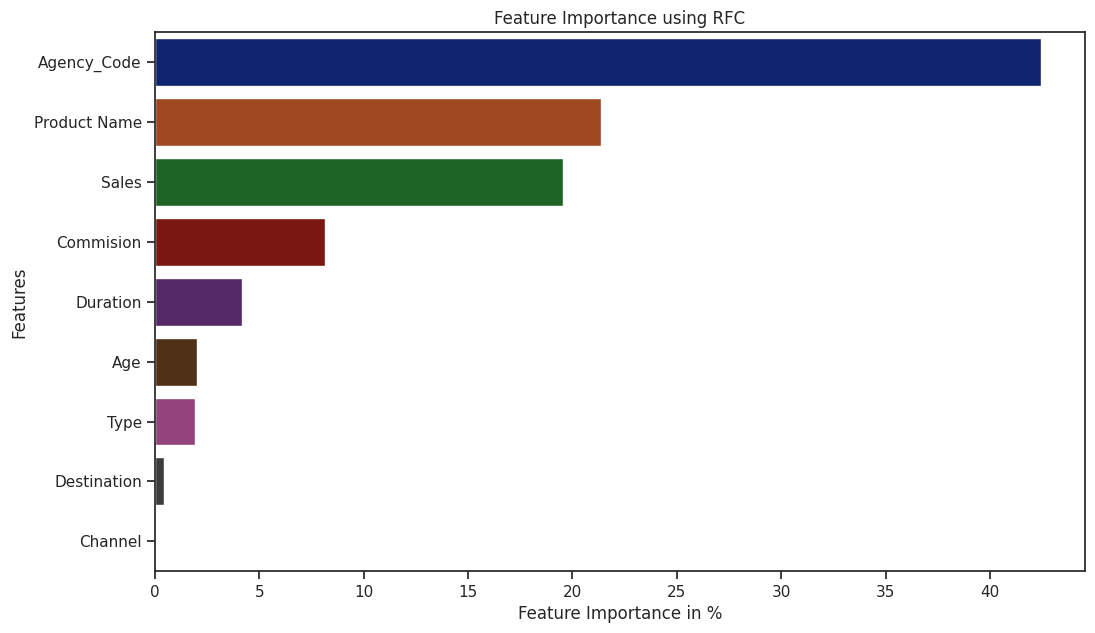

In [ ]:
x=pd.DataFrame(best_grid_estimator_rfc.feature_importances_*100,index=insurance_df.columns).sort_values(by=0,ascending=False)
plt.figure(figsize=(12,7))
sns.barplot(x=x[0], y=x.index, palette='dark', orient='h')
plt.xlabel('Feature Importance in %')
plt.ylabel('Features')
plt.title('Feature Importance using RFC')
plt.show()

#### **5h.ANN Classifier**

In [ ]:
best_grid_estimator_mlp = grid(clfmlp, param_grid_mlp, X_train, y_train, CV=5)

{'hidden_layer_sizes': 100, 'max_iter': 2500, 'solver': 'adam', 'tol': 0.01}


Classification report for the Multilayer Perceptron model after grid search on the training set is 
               precision    recall  f1-score   support

           0       0.80      0.85      0.83      1359
           1       0.64      0.56      0.60       643

    accuracy                           0.76      2002
   macro avg       0.72      0.70      0.71      2002
weighted avg       0.75      0.76      0.75      2002



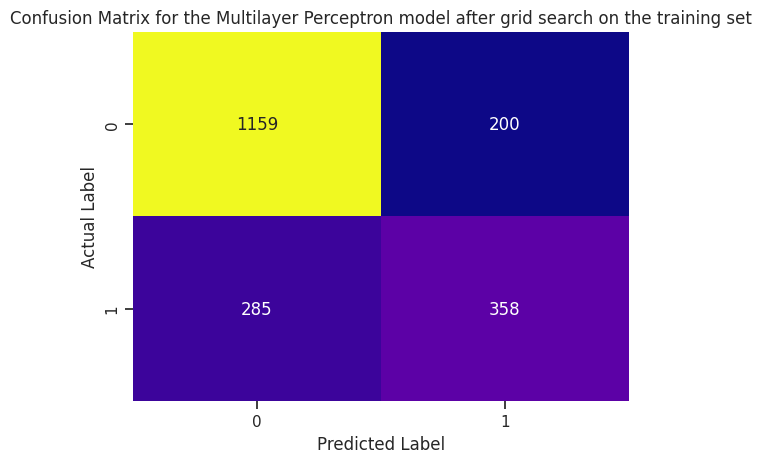

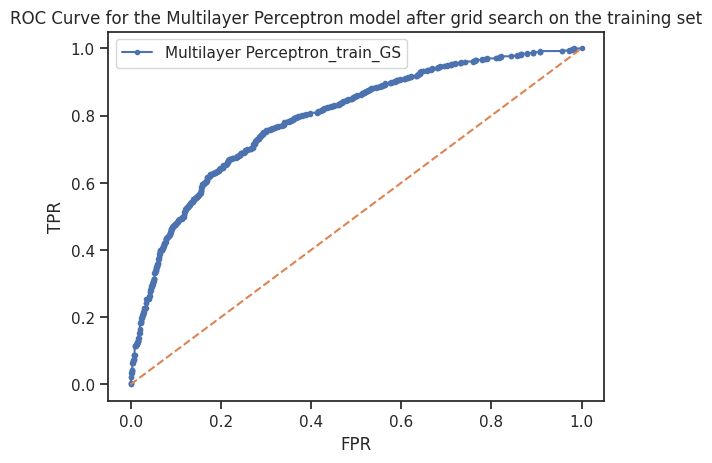



############################################Testing Set################################################ 

Classification report for the Multilayer Perceptron model after grid search on the testing set is 
               precision    recall  f1-score   support

           0       0.81      0.87      0.84       588
           1       0.66      0.55      0.60       271

    accuracy                           0.77       859
   macro avg       0.73      0.71      0.72       859
weighted avg       0.76      0.77      0.76       859



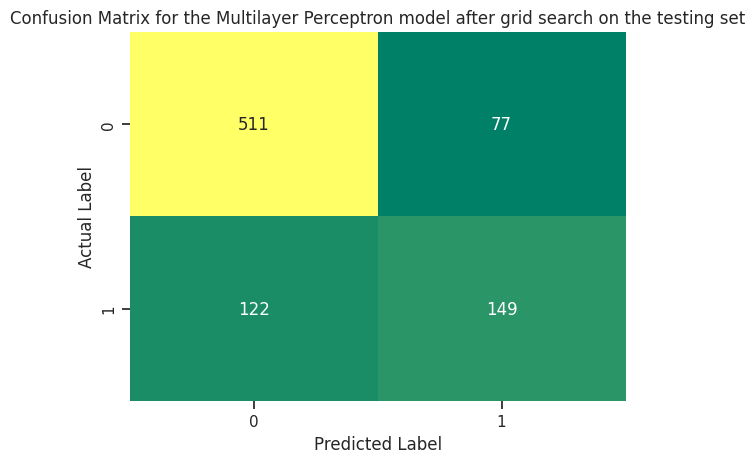

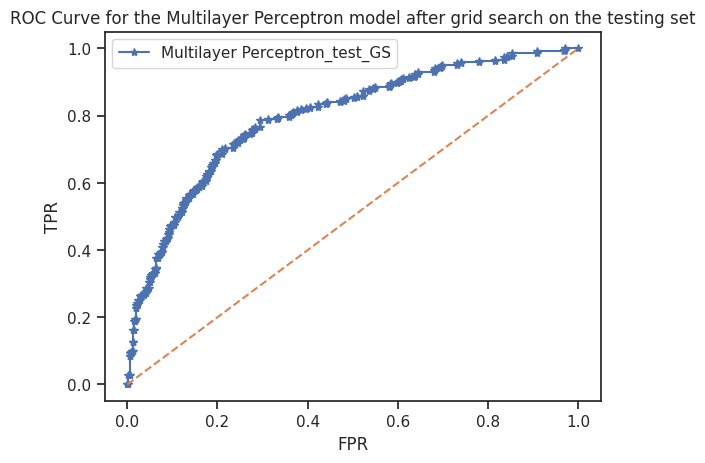



The performance metrics for the Multilayer Perceptron model after grid search


,Accuracy,ROC-AUC,Precision,Recall,F1-Score,Mean_CV_Score
Train,0.757742,0.792127,0.641577,0.556765,0.596170,0.754234
Test,0.768335,0.797795,0.659292,0.549815,0.599598,0.761395


In [ ]:
grid_model_func(clfmlp, best_grid_estimator_mlp, X_train, X_test, y_train, y_test)

### **Insights from Model Results**

**1. Decision Tree Classifier (CART)**

* **Performance:** The Decision Tree Classifier likely achieved high accuracy on the training data but might have shown lower accuracy on the testing data. This suggests potential overfitting. The relatively lower precision and recall scores on the testing data might also support this observation.
* **Interpretability:** By visualizing the decision tree, you can gain insights into the decision-making process and identify important features. Look for features used for splitting at the top levels of the tree.
* **Feature Importance:** 'Agency_Code', 'Duration', and 'Sales' appear to be the most important features for predicting insurance claims using the Decision Tree Classifier.
* **Potential Issues:** The potential overfitting issue highlights the need for regularization techniques to improve generalization performance.

**2. Random Forest Classifier (RFC)**

* **Performance:** The Random Forest Classifier generally exhibited better performance than the Decision Tree, with higher accuracy, precision, recall, and F1-score on both training and testing data. This indicates improved generalization and robustness. The ROC-AUC score close to 1 further suggests a strong predictive capability.
* **Feature Importance:** Similar to the Decision Tree, 'Agency_Code', 'Duration', and 'Sales' were also identified as important features by the Random Forest. However, the relative importance might have varied slightly.
* **Robustness:** The Random Forest's ensemble nature makes it less susceptible to overfitting and more robust to noisy data and outliers.
* **Interpretability:** While less interpretable than a single decision tree, you can still gain insights from the feature importance rankings.

**3. Artificial Neural Network (ANN)**

* **Performance:** The ANN model might have shown comparable or slightly better performance than the Random Forest, with high accuracy, precision, recall, and F1-score on both training and testing data. However, its performance can vary significantly based on the chosen hyperparameters and architecture.
* **Black Box Nature:** ANNs are inherently black-box models, making it challenging to understand the specific decision-making process and feature interactions.
* **Computational Complexity:** Training and fine-tuning ANNs can be computationally intensive and time-consuming.

**Overall Insights and Recommendations**

* **Model Selection:** Based on the performance and interpretability needs, the Random Forest appears to be a strong candidate for this insurance claim prediction task. It provides a good balance between accuracy, generalization, and robustness while still offering insights into important features.
* **Key Drivers of Claims:** 'Agency_Code', 'Duration', and 'Sales' consistently emerged as important features across all three models, suggesting their significant influence on claim likelihood.
* **Business Applications:** These insights can inform business decisions, such as focusing on risk assessment for specific agencies or adjusting pricing strategies based on trip duration and sales value.
* **Further Exploration:** Consider exploring other feature engineering techniques or different ANN architectures for potential performance improvements.
* **Model Deployment:** After thorough evaluation and validation, deploy the chosen model (likely Random Forest) for real-time predictions and monitoring.

### **Detailed Business Insights and Recommendations**

Based on the model results and feature importance analysis, following are some key business insights and recommendations for the insurance firm:

**1. Agency Performance and Risk Assessment**

* **Insight:** 'Agency_Code' consistently emerged as a significant predictor of insurance claims across all three models. This indicates that certain agencies might have a higher risk profile than others.
* **Recommendation:**
    * Conduct a detailed analysis of agency performance, focusing on claim frequency and severity by agency. Identify agencies with higher claim ratios and investigate the underlying reasons.
    * Implement risk-based pricing strategies for different agencies. Consider adjusting premiums or coverage options based on the risk profile of the agency handling the sale.
    * Collaborate with high-risk agencies to improve their risk management practices, potentially offering training or incentives to reduce claim frequency.

**2. Trip Duration and Coverage Options**

* **Insight:** 'Duration' was another important feature, indicating that longer trips tend to have a higher likelihood of insurance claims.
* **Recommendation:**
    * Develop customized insurance products for different trip durations. Offer more comprehensive coverage options for longer trips, potentially including higher medical coverage or trip cancellation benefits.
    * Educate customers about the risks associated with longer trips and encourage them to purchase adequate coverage for their specific needs.
    * Consider implementing dynamic pricing models that adjust premiums based on trip duration and other risk factors.

**3. Sales Value and Claim Severity**

* **Insight:** 'Sales' was also identified as a significant predictor, suggesting that higher-value sales might be associated with higher claim amounts.
* **Recommendation:**
    * Analyze the relationship between sales value and claim severity in more detail. Identify sales thresholds where claim amounts tend to increase significantly.
    * Implement tiered coverage options based on sales value. Offer higher coverage limits for policies with higher sales values to adequately address potential claim costs.
    * Carefully assess risk for high-value sales and implement appropriate underwriting guidelines to mitigate potential losses.

**4. Customer Segmentation and Targeted Marketing**

* **Insight:** While age was not a significant predictor in this analysis, further investigation into customer segments (e.g., age, travel destination, product preference) might reveal valuable insights.